# Long HW 1

## Problem 1 - Stochastic gradient descent for the logistic regression

### Part A - Time taken for the code to train 50000 training examples

In [28]:
import theano
from theano import *
import theano.tensor as T
import pandas as pd
import numpy as np

import gzip, pickle, time
import numpy as np
import matplotlib.pyplot as plt

#======================#
#loading the dataset into notebook as well as theano GPU#
#======================#
dataset=r"C:\Users\Dell\Documents\Python Scripts\mnist.pkl.gz"

with gzip.open(dataset, 'rb') as f:
        try:
            train_set, valid_set, test_set = pickle.load(f, encoding='latin1')
        except:
            train_set, valid_set, test_set = pickle.load(f)

def shared_dataset(data_xy, borrow=True):
    data_x, data_y = data_xy
    shared_x = theano.shared(np.asarray(data_x,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    shared_y = theano.shared(np.asarray(data_y,
                                           dtype=theano.config.floatX),
                             borrow=borrow)
    return shared_x, T.cast(shared_y, 'int32')
   
test_set_x, test_set_y = shared_dataset(test_set)
valid_set_x, valid_set_y = shared_dataset(valid_set)
train_set_x, train_set_y = shared_dataset(train_set)


#=====================#
#set up parameters #
#=====================#
batch_size = 256
n_train_batches = train_set[0].shape[0] // batch_size
n_valid_batches = valid_set[0].shape[0] // batch_size
n_test_batches = test_set[0].shape[0] // batch_size

learning_rate = 0.1

L2_reg = 0.01
n_in=28 * 28
n_out=10

#==========================#
# Setting up Theano Graph  #
#==========================#

x = T.matrix('x')  # data, presented as rasterized images
y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

W = theano.shared(value=np.zeros((n_in, n_out),
                    dtype=theano.config.floatX),
                name='W',
                borrow=True
            )
b = theano.shared(value=np.zeros(
                    (n_out,),
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)   
y_pred = T.argmax(p_y_given_x, axis=1)
params = [W, b]
L2_sqr = (W ** 2).sum()
log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
errors = T.mean(T.neq(y_pred, y))

cost = (log_likelihood+ L2_reg * L2_sqr)   
g_W = T.grad(cost=cost, wrt=W)
g_b = T.grad(cost=cost, wrt=b)
updates = [(W, W - learning_rate * g_W),
           (b, b - learning_rate * g_b)]

#running the model
index = T.lscalar()

#training the model through logistic regression 
train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )
    

#Run the model batch by batch and see how average cost decrease over time 
avg_cost = []

#start running the algorithm
start_time = time.time()

for minibatch_index in range(n_train_batches):
    minibatch_avg_cost = train_model(minibatch_index)
    avg_cost.append(minibatch_avg_cost)

print("time taken to run the algorithm for one epoch = %f seconds" % (time.time() - start_time))



time taken to run the algorithm for one epoch = 0.111066 seconds


Visualizing the decrease in the cost function:

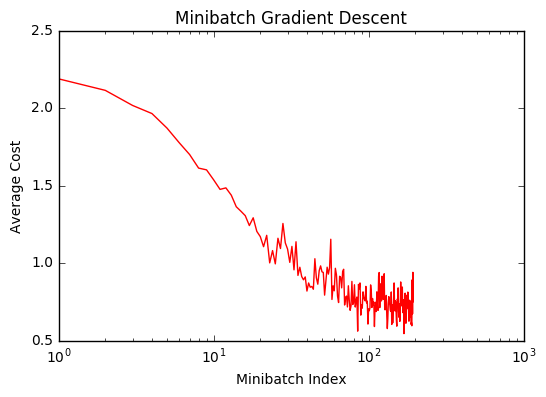

In [29]:
%matplotlib inline
plt.figure(figsize = [6,4])
plt.semilogx(range(len(avg_cost)),avg_cost,'r')
plt.title('Minibatch Gradient Descent')
plt.xlabel('Minibatch Index')
plt.ylabel('Average Cost')



### Part B(1) 
- Evaluate Validation Loss Function Periodically for Different Regularization Factors $\lambda $

In [30]:
learning_rate = 0.1

L2_set = [0.01,0.05,0.1,1]
n_in=28 * 28
n_out=10

for L2_reg in L2_set:  
    
    #==========================#
    # Setting up Theano Graph  #
    #==========================#
    
    x = T.matrix('x')  # data, presented as rasterized images
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

    W = theano.shared(value=np.zeros((n_in, n_out),
                        dtype=theano.config.floatX),
                    name='W',
                    borrow=True
                )
    b = theano.shared(value=np.zeros(
                        (n_out,),
                        dtype=theano.config.floatX
                    ),
                    name='b',
                    borrow=True
                )

    p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)   
    y_pred = T.argmax(p_y_given_x, axis=1)
    params = [W, b]
    L2_sqr = (W ** 2).sum()
    log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
    errors = T.mean(T.neq(y_pred, y))

    cost = (log_likelihood+ L2_reg * L2_sqr)   
    g_W = T.grad(cost=cost, wrt=W)
    g_b = T.grad(cost=cost, wrt=b)
    updates = [(W, W - learning_rate * g_W),
               (b, b - learning_rate * g_b)]

    #running the model
    index = T.lscalar()
    
    #training the model through logistic regression 
    train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )
    
    #calculating the validation loss using current weights matrix and errors vector
    validate_model = theano.function(
                inputs=[index],
                outputs=errors,
                givens={
                    x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                    y: valid_set_y[index * batch_size: (index + 1) * batch_size]
                }
            )

    #Run the model batch by batch and see how average cost decrease over time 
    avg_cost = []

    done_looping = False
    epoch = 0
    n_epochs=100
    validation_frequency = 100
    
    #start running the algorithm
    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):

            minibatch_avg_cost = train_model(minibatch_index)

            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index

            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                this_validation_loss = np.mean(validation_losses)
                avg_cost.append(this_validation_loss)

        if epoch == n_epochs:
            done_looping = True
            avg_cost_set.append(avg_cost)
            break
            

print('completed training the algorithm')



completed training the algorithm


Visualizing the validation loss function for different regularization factors:

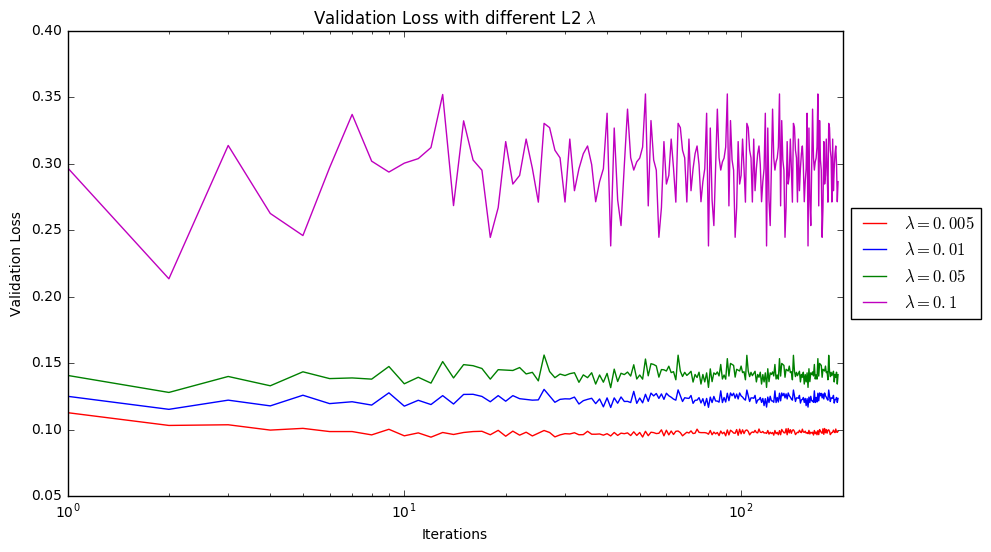

In [32]:
%matplotlib inline
plt.figure(figsize = [10,6])
plt.semilogx(range(len(avg_cost_set[0])),avg_cost_set[0],'r',label=u'$\lambda = 0.005$')
plt.semilogx(range(len(avg_cost_set[1])),avg_cost_set[1],'b',label=u'$\lambda = 0.01$')
plt.semilogx(range(len(avg_cost_set[2])),avg_cost_set[2],'g',label=u'$\lambda = 0.05$')
plt.semilogx(range(len(avg_cost_set[3])),avg_cost_set[3],'m',label=u'$\lambda = 0.1$')
plt.xlim([0,200])
plt.title('Validation Loss with different L2 $\lambda $')
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [33]:
#Implementing an early stop function where when the validation loss stops decreasing then I will wait for more iterations
#If there is still no improve then the algorithm will break and stop there

L2_set = [0.01,0.05,0.1,1]
avg_cost_early_stop = []
patience_num = []

for L2_reg in L2_set:
    #==========================#
    # Setting up Theano Graph  #
    #==========================#
    
    x = T.matrix('x')  # data, presented as rasterized images
    y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

    W = theano.shared(value=np.zeros((n_in, n_out),
                        dtype=theano.config.floatX),
                    name='W',
                    borrow=True
                )
    b = theano.shared(value=np.zeros(
                        (n_out,),
                        dtype=theano.config.floatX
                    ),
                    name='b',
                    borrow=True
                )

    p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)   
    y_pred = T.argmax(p_y_given_x, axis=1)
    params = [W, b]
    L2_sqr = (W ** 2).sum()
    log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
    errors = T.mean(T.neq(y_pred, y))

    cost = (log_likelihood+ L2_reg * L2_sqr)   
    g_W = T.grad(cost=cost, wrt=W)
    g_b = T.grad(cost=cost, wrt=b)
    updates = [(W, W - learning_rate * g_W),
               (b, b - learning_rate * g_b)]

    #running the model
    index = T.lscalar()
    
    #training the model through logistic regression 
    train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )
    
    #calculating the validation loss using current weights matrix and errors vector
    validate_model = theano.function(
                inputs=[index],
                outputs=errors,
                givens={
                    x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                    y: valid_set_y[index * batch_size: (index + 1) * batch_size]
                }
            )

    #Run the model batch by batch and see how average cost decrease over time 
    avg_cost = []

    
    #initialize running the model 
    epoch = 0
    n_epochs=100
    validation_frequency = 100
    best_validation_loss = np.inf
    improvement_threshold = 0.995
    patience_increase = 2
    patience = 5000
    done_looping = False

    while (epoch < n_epochs) and (not done_looping):
        epoch = epoch + 1
        for minibatch_index in range(n_train_batches):
    
            minibatch_avg_cost = train_model(minibatch_index)
            
            # iteration number
            iter = (epoch - 1) * n_train_batches + minibatch_index
    
            if (iter + 1) % validation_frequency == 0:
                # compute zero-one loss on validation set
                validation_losses = [validate_model(i)
                                     for i in range(n_valid_batches)]
                this_validation_loss = np.mean(validation_losses)
                avg_cost.append(this_validation_loss)
                
                if this_validation_loss < best_validation_loss:

                    if this_validation_loss < best_validation_loss * improvement_threshold:
                        patience = max(patience, iter * patience_increase)
                    
                    best_validation_loss = this_validation_loss        
                
        if patience <= iter:
            patience_num.append(iter)
            done_looping = True
            avg_cost_early_stop.append(avg_cost)
            break

Visualizing the validation loss after implementing the early stop:
Assuming we take 2 validation calculations in each epochs, then it stops at about epoch 25 (50/2) as visualized in the plot below

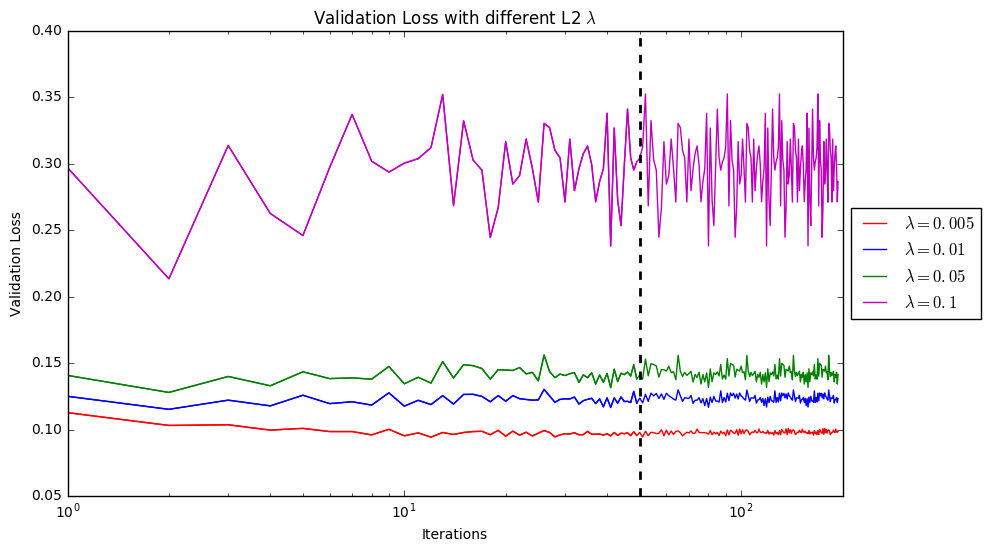

In [38]:
%matplotlib inline
plt.figure(figsize = [10,6])

#plotting the validation loss function without early stops
plt.semilogx(range(len(avg_cost_set[0])),avg_cost_set[0],'r',label=u'$\lambda = 0.005$')
plt.semilogx(range(len(avg_cost_set[1])),avg_cost_set[1],'b',label=u'$\lambda = 0.01$')
plt.semilogx(range(len(avg_cost_set[2])),avg_cost_set[2],'g',label=u'$\lambda = 0.05$')
plt.semilogx(range(len(avg_cost_set[3])),avg_cost_set[3],'m',label=u'$\lambda = 0.1$')

#plotting the validation loss function with early stops
plt.semilogx(range(len(avg_cost_early_stop[0])),avg_cost_early_stop[0],'r')
plt.semilogx(range(len(avg_cost_early_stop[1])),avg_cost_early_stop[1],'b')
plt.semilogx(range(len(avg_cost_early_stop[2])),avg_cost_early_stop[2],'g')
plt.semilogx(range(len(avg_cost_early_stop[3])),avg_cost_early_stop[3],'m')
plt.xlim([0,200])
plt.title('Validation Loss with different L2 $\lambda $')
plt.xlabel('Iterations')
plt.ylabel('Validation Loss')

#plotting the stopping period
plt.axvline(x=len(avg_cost_early_stop[3]), linewidth=2, color='k',ls='dashed')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

### Part B(3) 

- I am going to use $\lambda $ = 0.005

In [40]:
L2_reg = 0.005
#==========================#
# Setting up Theano Graph  #
#==========================#

x = T.matrix('x')  # data, presented as rasterized images
y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

W = theano.shared(value=np.zeros((n_in, n_out),
                    dtype=theano.config.floatX),
                name='W',
                borrow=True
            )
b = theano.shared(value=np.zeros(
                    (n_out,),
                    dtype=theano.config.floatX
                ),
                name='b',
                borrow=True
            )

p_y_given_x = T.nnet.softmax(T.dot(x, W) + b)   
y_pred = T.argmax(p_y_given_x, axis=1)
params = [W, b]
L2_sqr = (W ** 2).sum()
log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
errors = T.mean(T.neq(y_pred, y))

cost = (log_likelihood+ L2_reg * L2_sqr)   
g_W = T.grad(cost=cost, wrt=W)
g_b = T.grad(cost=cost, wrt=b)
updates = [(W, W - learning_rate * g_W),
           (b, b - learning_rate * g_b)]

#running the model
index = T.lscalar()

#training the model through logistic regression 
train_model = theano.function(
        inputs=[index],
        outputs=cost,
        updates=updates,
        givens={
            x: train_set_x[index * batch_size: (index + 1) * batch_size],
            y: train_set_y[index * batch_size: (index + 1) * batch_size]
        }
    )

#calculating the validation loss using current weights matrix and errors vector
validate_model = theano.function(
            inputs=[index],
            outputs=errors,
            givens={
                x: valid_set_x[index * batch_size: (index + 1) * batch_size],
                y: valid_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )

#testing the function
test_model = theano.function(
    inputs=[index],
    outputs=errors,
    givens={
        x: test_set_x[index * batch_size: (index + 1) * batch_size],
        y: test_set_y[index * batch_size: (index + 1) * batch_size]})

#Run the model batch by batch and see how average cost decrease over time 
avg_cost = []


#initialize running the model 
epoch = 0
n_epochs=100
validation_frequency = 100
best_validation_loss = np.inf
improvement_threshold = 0.995
patience_increase = 2
patience = 5000
done_looping = False

while (epoch < n_epochs) and (not done_looping):
    epoch = epoch + 1
    for minibatch_index in range(n_train_batches):

        minibatch_avg_cost = train_model(minibatch_index)

        # iteration number
        iter = (epoch - 1) * n_train_batches + minibatch_index

        if (iter + 1) % validation_frequency == 0:
            # compute zero-one loss on validation set
            validation_losses = [validate_model(i)
                                 for i in range(n_valid_batches)]
            this_validation_loss = np.mean(validation_losses)
            avg_cost.append(this_validation_loss)

            if this_validation_loss < best_validation_loss:

                if this_validation_loss < best_validation_loss * improvement_threshold:
                    patience = max(patience, iter * patience_increase)

                best_validation_loss = this_validation_loss        

    if patience <= iter:
        patience_num.append(iter)
        done_looping = True
        avg_cost_early_stop.append(avg_cost)
        break

test_losses = [test_model(i)for i in range(n_test_batches)]
test_score = np.mean(test_losses)
print('The test error is',test_score)

The test error is 0.0931490384615


## Problem 2: Multilayer Perceptron (with one hidden layer)

### Part A - Use different batch size and hidder units to experiment

In [47]:
#=====================#
#set up parameters #
#=====================#
batch_size_set = [20,50,100]
hidden_set = [50,100,200]
avg_cost_set = []

for batch_size in batch_size_set:
    for n_hidden in hidden_set:
        
        n_train_batches = train_set[0].shape[0] // batch_size
        n_valid_batches = valid_set[0].shape[0] // batch_size
        n_test_batches = test_set[0].shape[0] // batch_size

        learning_rate = 0.1
        L2_reg = 0.001
        avg_cost_early_stop = []
        patience_num = []

        #==========================#
        # Setting up Theano Graph  #
        #==========================#
        x = T.matrix('x')  # data, presented as rasterized images
        y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

        n_in = 28*28
        n_out = 10
        rng = np.random.RandomState(1234)


        ######For the hidden layer ######
        W_values = numpy.asarray(rng.uniform(
                            #adding the initializing level as suggested in the guidelines
                            low=-numpy.sqrt(6. / (n_in + n_hidden)),
                            high=numpy.sqrt(6. / (n_in + n_hidden)),
                            size=(n_in, n_hidden)),dtype=theano.config.floatX)
        W_hidden = theano.shared(value=W_values, name='W_hidden', borrow=True)
        b_values = numpy.zeros((n_hidden,), dtype=theano.config.floatX)
        b_hidden = theano.shared(value=b_values, name='b_hidden', borrow=True)

        lin_output = T.dot(x, W_hidden) + b_hidden
        final_output = T.tanh(lin_output)
        hiddenparams = [W_hidden,b_hidden]
        
        ######For Logistics Regression Layer ########
        W = theano.shared(value=np.zeros((n_hidden, n_out),
                            dtype=theano.config.floatX),
                        name='W',
                        borrow=True
                    )
        b = theano.shared(value=np.zeros(
                            (n_out,),
                            dtype=theano.config.floatX
                        ),
                        name='b',
                        borrow=True
                    )

        p_y_given_x = T.nnet.softmax(T.dot(final_output, W) + b)   
        y_pred = T.argmax(p_y_given_x, axis=1)

        log_params = [W, b]
        L2_sqr = (W_hidden**2).sum()+(W ** 2).sum()
        log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
        errors = T.mean(T.neq(y_pred, y))

        cost = (log_likelihood + L2_reg * L2_sqr)
        
        ####For the whole MLP Function   ###########
        MLP_params = log_params + hiddenparams
        gparams = [T.grad(cost, param) for param in MLP_params]
        
        # specify how to update the parameters of the model 
        updates = [(param, param - learning_rate * gparam) for param, gparam in zip(params, gparams)]        

        #running the model
        index = T.lscalar()
        
        ##Validation Function
        validate_model = theano.function(
            inputs=[index],
            outputs=errors,
            givens={
                x: valid_set_x[index * batch_size:(index + 1) * batch_size],
                y: valid_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )

        ## Training Function 
        train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )

        #Run the model batch by batch and see how average cost decrease over time 
        avg_cost = []
        n_epochs = 50
        epoch = 0
        done_looping = False
        validation_frequency = 100

        while (epoch < n_epochs) and (not done_looping):

            epoch = epoch + 1

            for minibatch_index in range(n_train_batches):
                minibatch_avg_cost = train_model(minibatch_index)
                # iteration number
                iter = (epoch - 1) * n_train_batches + minibatch_index

                if (iter + 1) % validation_frequency == 0:
                    # compute zero-one loss on validation set
                    validation_losses = [validate_model(i) for i in range(n_valid_batches)]
                    this_validation_loss = numpy.mean(validation_losses)
                    avg_cost.append(this_validation_loss)

            if epoch == n_epochs:
                done_looping = True
                avg_cost.append(this_validation_loss)
                break
        
        avg_cost_set.append(avg_cost)
        print("The algorithm takes %f seconds to run" % (time.time() - start_time))
        print(batch_size,n_hidden,'final loss',avg_cost[-1])


The algorithm takes 129.765942 seconds to run
20 50 0.0372
The algorithm takes 173.635823 seconds to run
20 100 0.0342
The algorithm takes 433.098344 seconds to run
20 200 0.0345
The algorithm takes 52.463093 seconds to run
50 50 0.0335
The algorithm takes 91.918019 seconds to run
50 100 0.0316
The algorithm takes 183.982129 seconds to run
50 200 0.0325
The algorithm takes 26.325604 seconds to run
100 50 0.0338
The algorithm takes 42.219852 seconds to run
100 100 0.0318
The algorithm takes 110.108887 seconds to run
100 200 0.033


This is another way to derive the same result:

In [ ]:
#=====================#
#set up parameters #
# testing combinations of 50,100,200 batch size #
# and 50,100,200 hidden units#
#=====================#

batch_size_set = [20,50,100]
hidden_set = [50,100,200]

for batch_size in batch_size_set:
    for n_hidden in hidden_set:

        n_train_batches = train_set[0].shape[0] // batch_size
        n_valid_batches = valid_set[0].shape[0] // batch_size
        n_test_batches = test_set[0].shape[0] // batch_size

        learning_rate = 0.1
        L2_reg = 0.001

        #=====================#
        #construct the hidden layers 
        #=====================#

        class HiddenLayer(object):
            def __init__(self, rng, input, n_in, n_out, W=None, b=None,
                         activation=T.tanh):

                self.input = input

                if W is None:
                    W_values = numpy.asarray(
                        rng.uniform(
                            #adding the initializing level as suggested in the guidelines
                            low=-numpy.sqrt(6. / (n_in + n_out)),
                            high=numpy.sqrt(6. / (n_in + n_out)),
                            size=(n_in, n_out)
                        ),
                        dtype=theano.config.floatX
                    )
                    if activation == theano.tensor.nnet.sigmoid:
                        W_values *= 4

                    W = theano.shared(value=W_values, name='W', borrow=True)

                if b is None:
                    b_values = numpy.zeros((n_out,), dtype=theano.config.floatX)
                    b = theano.shared(value=b_values, name='b', borrow=True)

                self.W = W
                self.b = b

                lin_output = T.dot(input, self.W) + self.b
                self.output = (
                    lin_output if activation is None
                    else activation(lin_output)
                )
                # parameters of the model
                self.params = [self.W, self.b]

        #=====================#
        #creating the logistic regression class #
        #=====================#

        class LogisticRegression(object):

            def __init__(self, input, n_in, n_out):
                # initialize with 0 the weights W as a matrix of shape (n_in, n_out)
                self.W = theano.shared(
                    value=np.zeros(
                        (n_in, n_out),
                        dtype=theano.config.floatX
                    ),
                    name='W',
                    borrow=True
                )
                # initialize the biases b as a vector of n_out 0s
                self.b = theano.shared(
                    value=np.zeros(
                        (n_out,),
                        dtype=theano.config.floatX
                    ),
                    name='b',
                    borrow=True
                )

                # symbolic expression for computing the matrix of class-membership
                # probabilities
                self.p_y_given_x = T.nnet.softmax(T.dot(input, self.W) + self.b)

                # symbolic description of how to compute prediction as class whose
                # probability is maximal
                self.y_pred = T.argmax(self.p_y_given_x, axis=1)
                # end-snippet-1

                # parameters of the model
                self.params = [self.W, self.b]

                # keep track of model input
                self.input = input

                #computing sum of squares of paramters 
                self.L2_sqr = (self.W ** 2).sum()

            def negative_log_likelihood(self, y):
                """Return the mean of the negative log-likelihood of the prediction
                of this model under a given target distribution.
                """

                return -T.mean(T.log(self.p_y_given_x)[T.arange(y.shape[0]), y])
                # end-snippet-2

            def errors(self, y):
                """Return a float representing the number of errors in the minibatch
                over the total number of examples of the minibatch ; zero one
                loss over the size of the minibatch
                """

                # check if y has same dimension of y_pred
                if y.ndim != self.y_pred.ndim:
                    raise TypeError(
                        'y should have the same shape as self.y_pred',
                        ('y', y.type, 'y_pred', self.y_pred.type)
                    )
                # check if y is of the correct datatype
                if y.dtype.startswith('int'):
                    # the T.neq operator returns a vector of 0s and 1s, where 1
                    # represents a mistake in prediction
                    return T.mean(T.neq(self.y_pred, y))
                else:
                    raise NotImplementedError()

        class MLP(object):

            def __init__(self, rng, input, n_in, n_hidden, n_out):

                self.hiddenLayer = HiddenLayer(
                    rng=rng,
                    input=input,
                    n_in=n_in,
                    n_out=n_hidden,
                    activation=T.tanh
                )

                self.logRegressionLayer = LogisticRegression(
                    input=self.hiddenLayer.output,
                    n_in=n_hidden,
                    n_out=n_out
                )


                self.L2_sqr = (
                    (self.hiddenLayer.W ** 2).sum()
                    + (self.logRegressionLayer.W ** 2).sum()
                )

                # negative log likelihood of the MLP is given by the negative
                # log likelihood of the output of the model, computed in the
                # logistic regression layer
                self.negative_log_likelihood = (
                    self.logRegressionLayer.negative_log_likelihood
                )
                # same holds for the function computing the number of errors
                self.errors = self.logRegressionLayer.errors

                # the parameters of the model are the parameters of the two layer it is
                # made out of
                self.params = self.hiddenLayer.params + self.logRegressionLayer.params
                # end-snippet-3

                # keep track of model input
                self.input = input



        #######################
        #Later on#
        ######################
        index = T.lscalar()
        x = T.matrix('x')  # data, presented as rasterized images
        y = T.ivector('y')  # labels, presented as 1D vector of [int] labels
        rng = np.random.RandomState(1234)



        # construct the MLP class
        classifier = MLP(
            rng=rng,
            input=x,
            n_in=28 * 28,
            n_hidden=n_hidden,
            n_out=10
        )


        cost = (classifier.negative_log_likelihood(y) + L2_reg * classifier.L2_sqr)


        # compiling a Theano function that computes the mistakes that are made
        # by the model on a minibatch
        test_model = theano.function(
            inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: test_set_x[index * batch_size:(index + 1) * batch_size],
                y: test_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )

        validate_model = theano.function(
            inputs=[index],
            outputs=classifier.errors(y),
            givens={
                x: valid_set_x[index * batch_size:(index + 1) * batch_size],
                y: valid_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )

        # compute the gradient of cost with respect to theta (sorted in params)
        gparams = [T.grad(cost, param) for param in classifier.params]

        # specify how to update the parameters of the model as a list of
        updates = [(param, param - learning_rate * gparam)
            for param, gparam in zip(classifier.params, gparams)]

        # compiling a Theano function `train_model` that returns the cost, but
        # in the same time updates the parameter of the model based on the rules
        # defined in `updates`
        train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )


        start_time = time.time()

        n_epochs = 50
        epoch = 0
        done_looping = False
        avg_cost = []
        validation_frequency = 100



        while (epoch < n_epochs) and (not done_looping):

            epoch = epoch + 1

            for minibatch_index in range(n_train_batches):
                minibatch_avg_cost = train_model(minibatch_index)
                # iteration number
                iter = (epoch - 1) * n_train_batches + minibatch_index

                if (iter + 1) % validation_frequency == 0:
                    # compute zero-one loss on validation set
                    validation_losses = [validate_model(i) for i in range(n_valid_batches)]
                    this_validation_loss = numpy.mean(validation_losses)
                    avg_cost.append(this_validation_loss)

            if epoch == n_epochs:
                done_looping = True
                avg_cost.append(this_validation_loss)
                break

        print("The algorithm takes %f seconds to run" % (time.time() - start_time))
        print(batch_size, n_hidden, avg_cost[-1])

Looking at the result above, with batch size = 50 and hidden units = 100 yields the lowest validation loss which is 0.0316.

In [ ]:
#=====================#
#set up parameters #
#=====================#
batch_size_set = [50]
hidden_set = [100]
avg_cost_set = []

for batch_size in batch_size_set:
    for n_hidden in hidden_set:
        
        n_train_batches = train_set[0].shape[0] // batch_size
        n_valid_batches = valid_set[0].shape[0] // batch_size
        n_test_batches = test_set[0].shape[0] // batch_size

        learning_rate = 0.1
        L2_reg = 0.001
        avg_cost_early_stop = []
        patience_num = []

        #==========================#
        # Setting up Theano Graph  #
        #==========================#
        x = T.matrix('x')  # data, presented as rasterized images
        y = T.ivector('y')  # labels, presented as 1D vector of [int] labels

        n_in = 28*28
        n_out = 10
        rng = np.random.RandomState(1234)


        ######For the hidden layer ######
        W_values = numpy.asarray(rng.uniform(
                            #adding the initializing level as suggested in the guidelines
                            low=-numpy.sqrt(6. / (n_in + n_hidden)),
                            high=numpy.sqrt(6. / (n_in + n_hidden)),
                            size=(n_in, n_hidden)),dtype=theano.config.floatX)
        W_hidden = theano.shared(value=W_values, name='W_hidden', borrow=True)
        b_values = numpy.zeros((n_hidden,), dtype=theano.config.floatX)
        b_hidden = theano.shared(value=b_values, name='b_hidden', borrow=True)

        lin_output = T.dot(x, W_hidden) + b_hidden
        final_output = T.tanh(lin_output)
        hiddenparams = [W_hidden,b_hidden]
        
        ######For Logistics Regression Layer ########
        W = theano.shared(value=np.zeros((n_hidden, n_out),
                            dtype=theano.config.floatX),
                        name='W',
                        borrow=True
                    )
        b = theano.shared(value=np.zeros(
                            (n_out,),
                            dtype=theano.config.floatX
                        ),
                        name='b',
                        borrow=True
                    )

        p_y_given_x = T.nnet.softmax(T.dot(final_output, W) + b)   
        y_pred = T.argmax(p_y_given_x, axis=1)

        log_params = [W, b]
        L2_sqr = (W_hidden**2).sum()+(W ** 2).sum()
        log_likelihood = -T.mean(T.log(p_y_given_x)[T.arange(y.shape[0]), y])
        errors = T.mean(T.neq(y_pred, y))

        cost = (log_likelihood + L2_reg * L2_sqr)
        
        ####For the whole MLP Function   ###########
        MLP_params = log_params + hiddenparams
        gparams = [T.grad(cost, param) for param in MLP_params]
        
        # specify how to update the parameters of the model 
        updates = [(param, param - learning_rate * gparam) for param, gparam in zip(params, gparams)]        

        #running the model
        index = T.lscalar()
        
        ##Validation Function
        validate_model = theano.function(
            inputs=[index],
            outputs=errors,
            givens={
                x: valid_set_x[index * batch_size:(index + 1) * batch_size],
                y: valid_set_y[index * batch_size:(index + 1) * batch_size]
            }
        )

        ## Training Function 
        train_model = theano.function(
            inputs=[index],
            outputs=cost,
            updates=updates,
            givens={
                x: train_set_x[index * batch_size: (index + 1) * batch_size],
                y: train_set_y[index * batch_size: (index + 1) * batch_size]
            }
        )

        #Run the model batch by batch and see how average cost decrease over time 
        avg_cost = []
        n_epochs = 50
        epoch = 0
        done_looping = False
        validation_frequency = 100

        while (epoch < n_epochs) and (not done_looping):

            epoch = epoch + 1

            for minibatch_index in range(n_train_batches):
                minibatch_avg_cost = train_model(minibatch_index)
                # iteration number
                iter = (epoch - 1) * n_train_batches + minibatch_index

                if (iter + 1) % validation_frequency == 0:
                    # compute zero-one loss on validation set
                    validation_losses = [validate_model(i) for i in range(n_valid_batches)]
                    this_validation_loss = numpy.mean(validation_losses)
                    avg_cost.append(this_validation_loss)

            if epoch == n_epochs:
                done_looping = True
                avg_cost.append(this_validation_loss)
                break
        
        avg_cost_set.append(avg_cost)
        print("The algorithm takes %f seconds to run" % (time.time() - start_time))
        print(batch_size,n_hidden,'final loss',avg_cost[-1])


In [48]:
test_model = theano.function(
        inputs=[index],
        outputs=errors,
        givens={
            x: test_set_x[index * batch_size:(index + 1) * batch_size],
            y: test_set_y[index * batch_size:(index + 1) * batch_size]
        }
    )

test_losses = [test_model(i) for i in range(n_test_batches)]
test_score = np.mean(test_losses)
print(test_score)

0.0346


Test Error = 0.0316 which is one third of 0.0931 from test error of stochastic descent because the multilayer enables the algorithm to draw better separation curves. 